# Modelli lineari generalizzati {#sec-stan-glm}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "stan_binomial_regression"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

In questo capitolo, esploreremo i Modelli Lineari Generalizzati (GLM) e, in particolare, il modello di regressione binomiale, che è un'applicazione specifica dei GLM. Discuteremo anche come affrontare questo tipo di modelli utilizzando un approccio bayesiano e illustreremo come implementare la regressione binomiale con Stan.

## Probabilità, Odds e Logit

Nel contesto dei GLM, è essenziale comprendere le relazioni tra probabilità, odds e logit. La probabilità $P$ rappresenta la possibilità di successo di un evento ed è un valore compreso tra 0 e 1. Gli **odds** (o rapporti di possibilità) rappresentano il rapporto tra la probabilità di successo e quella di insuccesso, calcolato come $O = \frac{P}{1 - P}$. Il **logit** è il logaritmo naturale degli odds, dato dalla formula $L = \ln(O) = \ln\left(\frac{P}{1 - P}\right)$. 

Queste trasformazioni sono fondamentali nei GLM perché consentono di trattare probabilità che, per definizione, sono limitate all'intervallo (0, 1) trasformandole in un intervallo che può coprire tutti i numeri reali. Ad esempio, quando la probabilità $P = 0.5$, gli odds sono 1 e il logit è 0. Logit negativi indicano probabilità inferiori a 0.5, mentre logit positivi indicano probabilità superiori a 0.5.

| Probabilità (P) | Odds (O)            | Logit (L)                           |
|-----------------|---------------------|-------------------------------------|
| 0.01            | $\frac{0.01}{0.99}$ = 0.0101 | $\ln\left(\frac{0.01}{0.99}\right)$ = -4.60 |
| 0.05            | $\frac{0.05}{0.95}$ = 0.0526 | $\ln\left(\frac{0.05}{0.95}\right)$ = -2.94 |
| 0.10            | $\frac{0.10}{0.90}$ = 0.1111 | $\ln\left(\frac{0.10}{0.90}\right)$ = -2.20 |
| 0.30            | $\frac{0.30}{0.70}$ = 0.4286 | $\ln\left(\frac{0.30}{0.70}\right)$ = -0.85 |
| 0.50            | $\frac{0.50}{0.50}$ = 1      | $\ln\left(\frac{0.50}{0.50}\right)$ = 0.00  |
| 0.70            | $\frac{0.70}{0.30}$ = 2.3333 | $\ln\left(\frac{0.70}{0.30}\right)$ = 0.85  |
| 0.90            | $\frac{0.90}{0.10}$ = 9      | $\ln\left(\frac{0.90}{0.10}\right)$ = 2.20  |
| 0.95            | $\frac{0.95}{0.05}$ = 19     | $\ln\left(\frac{0.95}{0.05}\right)$ = 2.94  |
| 0.99            | $\frac{0.99}{0.01}$ = 99     | $\ln\left(\frac{0.99}{0.01}\right)$ = 4.60  |

### Trasformazione Inversa del Logit

La **trasformazione inversa del logit**, nota anche come *antilogit*, consente di riconvertire un logit in una probabilità. Questa funzione è definita come:

$$
\pi_i = \frac{e^{\eta_i}}{1 + e^{\eta_i}},
$$

dove $\eta_i$ è il predittore lineare. Questa trasformazione garantisce che la stima risultante, $\pi_i$, sia sempre compresa tra 0 e 1, rendendola interpretabile come una probabilità. Questo è particolarmente utile nei modelli come la regressione binomiale, dove si cerca di modellare la probabilità di successo di un evento binario.

## Modelli Lineari Generalizzati

I **Modelli Lineari Generalizzati (GLM)** estendono la regressione lineare per affrontare situazioni in cui la variabile dipendente non segue una distribuzione normale e non esiste una relazione lineare tra le variabili indipendenti e dipendenti. Questa flessibilità consente di modellare diversi tipi di dati, come conteggi, proporzioni o dati categoriali.

Un GLM si compone di tre elementi principali:

1. **Componente Aleatoria**: descrive la distribuzione della variabile risposta $Y$, che può provenire da una qualsiasi distribuzione della famiglia esponenziale. Ad esempio, se $Y$ rappresenta un conteggio, si potrebbe usare una distribuzione di Poisson.

2. **Componente Sistematica**: rappresenta il predittore lineare $\eta$, una combinazione delle variabili indipendenti $X$, espressa come $\eta = \beta_0 + \beta_1 X_1 + \dots + \beta_k X_k$, dove $\beta$ sono i parametri del modello.

3. **Funzione di Legame**: stabilisce la relazione tra la media attesa della variabile risposta $\mu = E(Y)$ e il predittore lineare $\eta$. Questa funzione di legame, $g(\mu) = \eta$, permette di adattare il modello alla natura specifica dei dati. Ad esempio, nella regressione logistica, la funzione di legame è il logit, che trasforma la probabilità di successo $p$ in un valore lineare:
   
$$
g(p) = \ln\left(\frac{p}{1-p}\right).
$$


### Modello Normale
Il modello osservativo in questo caso segue una distribuzione normale con parametri media $\mu$ e varianza del rumore $\sigma^2$:

$$
p(y|\mu, \sigma) = \mathcal{N}(y|\mu, \sigma^2),\
\mu = \eta.
$$

In questo modello, la funzione di legame canonica è la funzione identità. Un esempio di questo modello è stato visto nella sezione sul "flusso di lavoro bayesiano", dove si calcolava $\mu = b_0 + b_1 * \text{peso}$.

### Modello di Poisson

In questo caso, le osservazioni sono valori interi non negativi, che si suppone seguano una distribuzione di Poisson con parametro di media $\lambda$:

$$
p(y|\lambda) = \text{Pois}(y|\lambda),\
\log(\lambda) = \eta.
$$

In questo modello, la funzione di legame è la funzione logaritmica, che consente di trasformare il predittore lineare $\eta$, definito nello spazio reale continuo, nel parametro $\lambda$ della distribuzione di Poisson, garantendo che $\lambda$ sia sempre positivo (o zero):

$$
\lambda = \exp(\eta).
$$

### Modello Binomiale
Le osservazioni in questo modello sono binarie, cioè $y \in \{0, 1\}$. Queste osservazioni si suppone seguano una distribuzione binomiale con parametro di probabilità $p$:

$$
p(y|\eta) = \text{Binom}(p),\
\text{logit}(p) = \eta.
$$

In questo caso, la probabilità $p$ è collegata al predittore lineare $\eta$ tramite la trasformazione logistica $\text{logit}(·)$, che converte i valori del predittore lineare (solitamente definiti nello spazio reale continuo) in valori di probabilità compresi nell'intervallo $[0, 1]$. In alternativa, è possibile usare anche la funzione di legame 'probit' per ottenere lo stesso effetto.

### Modello Categoriale

Il modello categoriale, noto anche come "multinomiale", viene utilizzato nei problemi di classificazione multi-classe, dove le osservazioni possono assumere valori appartenenti a più classi $y \in \{1, . . . , J\}$. In questo caso, il modello osservativo segue una distribuzione multinomiale:

$$
p(y | p) = \text{Categorical}(p),\
p = \text{softmax}(\eta),
$$

dove $p = (p_1, \dots, p_J)$ è un vettore di probabilità associate a ciascuna classe. La somma delle probabilità per tutte le classi deve essere uguale a 1, ovvero $\sum_{j=1}^J p_j = 1$.

La probabilità di appartenere a una classe $j$ viene calcolata tramite la trasformazione 'softmax':

$$
p_j = \frac{\exp(\eta_j)}{\sum_{k=1}^J \exp(\eta_k)}.
$$

In questo modo, si ottiene una rappresentazione probabilistica per ogni classe, garantendo che le probabilità siano sempre non negative e sommino a 1.

### Approccio Bayesiano

In un contesto bayesiano, i parametri del modello, come $\mu$ e $\phi$, sono associati a distribuzioni a priori. Quando si modella $\mu$ attraverso un predittore lineare, si specificano le distribuzioni a priori sui parametri $\beta$ che definiscono tale predittore. Questo approccio consente di integrare informazioni a priori e aggiornare le stime sulla base dei dati osservati, migliorando la robustezza del modello e la sua interpretazione.

In sintesi, i GLM offrono un potente strumento per modellare dati complessi, fornendo flessibilità nella scelta delle distribuzioni e nelle relazioni tra variabili, e consentono di affrontare problemi in numerosi contesti applicativi.

## Un esempio concreto

Seguiamo il tutorial fornito sul sito ufficiale di PyMC e generiamo dei dati sintetici dove $y$ indica il numero di successi in $n = 20$ prove e $x$ è un predittore.

In [2]:
# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})
display(data)

,x,y
0,-10.000000,1
1,-8.965517,0
2,-7.931034,1
3,-6.896552,2
4,-5.862069,6
5,-4.827586,7
6,-3.793103,4
7,-2.758621,14
8,-1.724138,14
9,-0.689655,9


Per questi dati, il modello di regressione binomiale può essere descritto come segue:

1. **Modello lineare**:
   $$
   \eta_i = \beta_0 + \beta_1 x_i
   $$

2. **Probabilità di successo**:
   $$
   p_i = \text{logit}^{-1}(\eta_i) = \frac{1}{1 + \exp(-\eta_i)}
   $$

3. **Likelihood**:
   $$
   y_i \mid p_i \sim \text{Binomiale}(n, p_i)
   $$

4. **Priori**:
   $$
   \beta_0 \sim \mathcal{N}(0, 1)
   $$
   $$
   \beta_1 \sim \mathcal{N}(0, 1)
   $$


Compiliamo il modello e stampiamo il codice Stan:

In [3]:
stan_file = os.path.join(project_directory, "stan", "binomial_regression.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=0> sample_size;  // Numero totale di osservazioni
  vector[sample_size] x;     // Variabile indipendente
  array[sample_size] int<lower=0> y;  // Successi per ogni tentativo
  int<lower=0> n;           // Numero di tentativi per osservazione
}
parameters {
  real beta0;  // Intercetta
  real beta1;  // Pendenza
}
transformed parameters {
  vector[sample_size] eta = beta0 + beta1 * x;  // Modello lineare
  vector[sample_size] p = inv_logit(eta);       // Probabilità di successo
}
model {
  // Priori
  beta0 ~ normal(0, 1);
  beta1 ~ normal(0, 1);

  // Likelihood
  y ~ binomial(n, p);
}



Creiamo un dizionario nel formato richiesto per l'input a CmdStan:

In [ ]:
stan_data = {
    "sample_size": data.shape[0],
    "x": data["x"],
    "y": data["y"],
    "n": 20
}

Eseguiamo il campionamento.

In [10]:
fit = model.sample(
    data=stan_data,
    iter_warmup=1000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

11:52:40 - cmdstanpy - INFO - CmdStan start processing
11:52:40 - cmdstanpy - INFO - Chain [1] start processing
11:52:40 - cmdstanpy - INFO - Chain [2] start processing
11:52:40 - cmdstanpy - INFO - Chain [3] start processing
11:52:40 - cmdstanpy - INFO - Chain [4] start processing
11:52:40 - cmdstanpy - INFO - Chain [2] done processing
11:52:40 - cmdstanpy - INFO - Chain [1] done processing
11:52:40 - cmdstanpy - INFO - Chain [4] done processing
11:52:40 - cmdstanpy - INFO - Chain [3] done processing


Per visualizzare e descrivere la distribuzione a posteriori dei parametri è possibile utilizzare ArviZ dopo aver fittato il modello con cmdstanpy. ArviZ utilizza un formato di dati chiamato `InferenceData`, che è un formato ad alto livello per la memorizzazione di risultati statistici. cmdstanpy restituisce un oggetto `CmdStanMCMC`, che può essere convertito in `InferenceData` utilizzando la funzione `az.from_cmdstanpy`.

In [11]:
idata = az.from_cmdstanpy(fit)

Otteniamo un riassunto delle statistiche posteriori:

In [12]:
summary = az.summary(fit, var_names=(["beta0", "beta1"]), hdi_prob=0.94)
print(summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  0.934  0.174   0.603    1.257      0.003    0.002    4147.0    4717.0   
beta1  0.462  0.043   0.381    0.543      0.001    0.000    4247.0    4317.0   

       r_hat  
beta0    1.0  
beta1    1.0  


Mostriamo le distribuzioni a posteriori e le tracce di campionamento per i parametri:

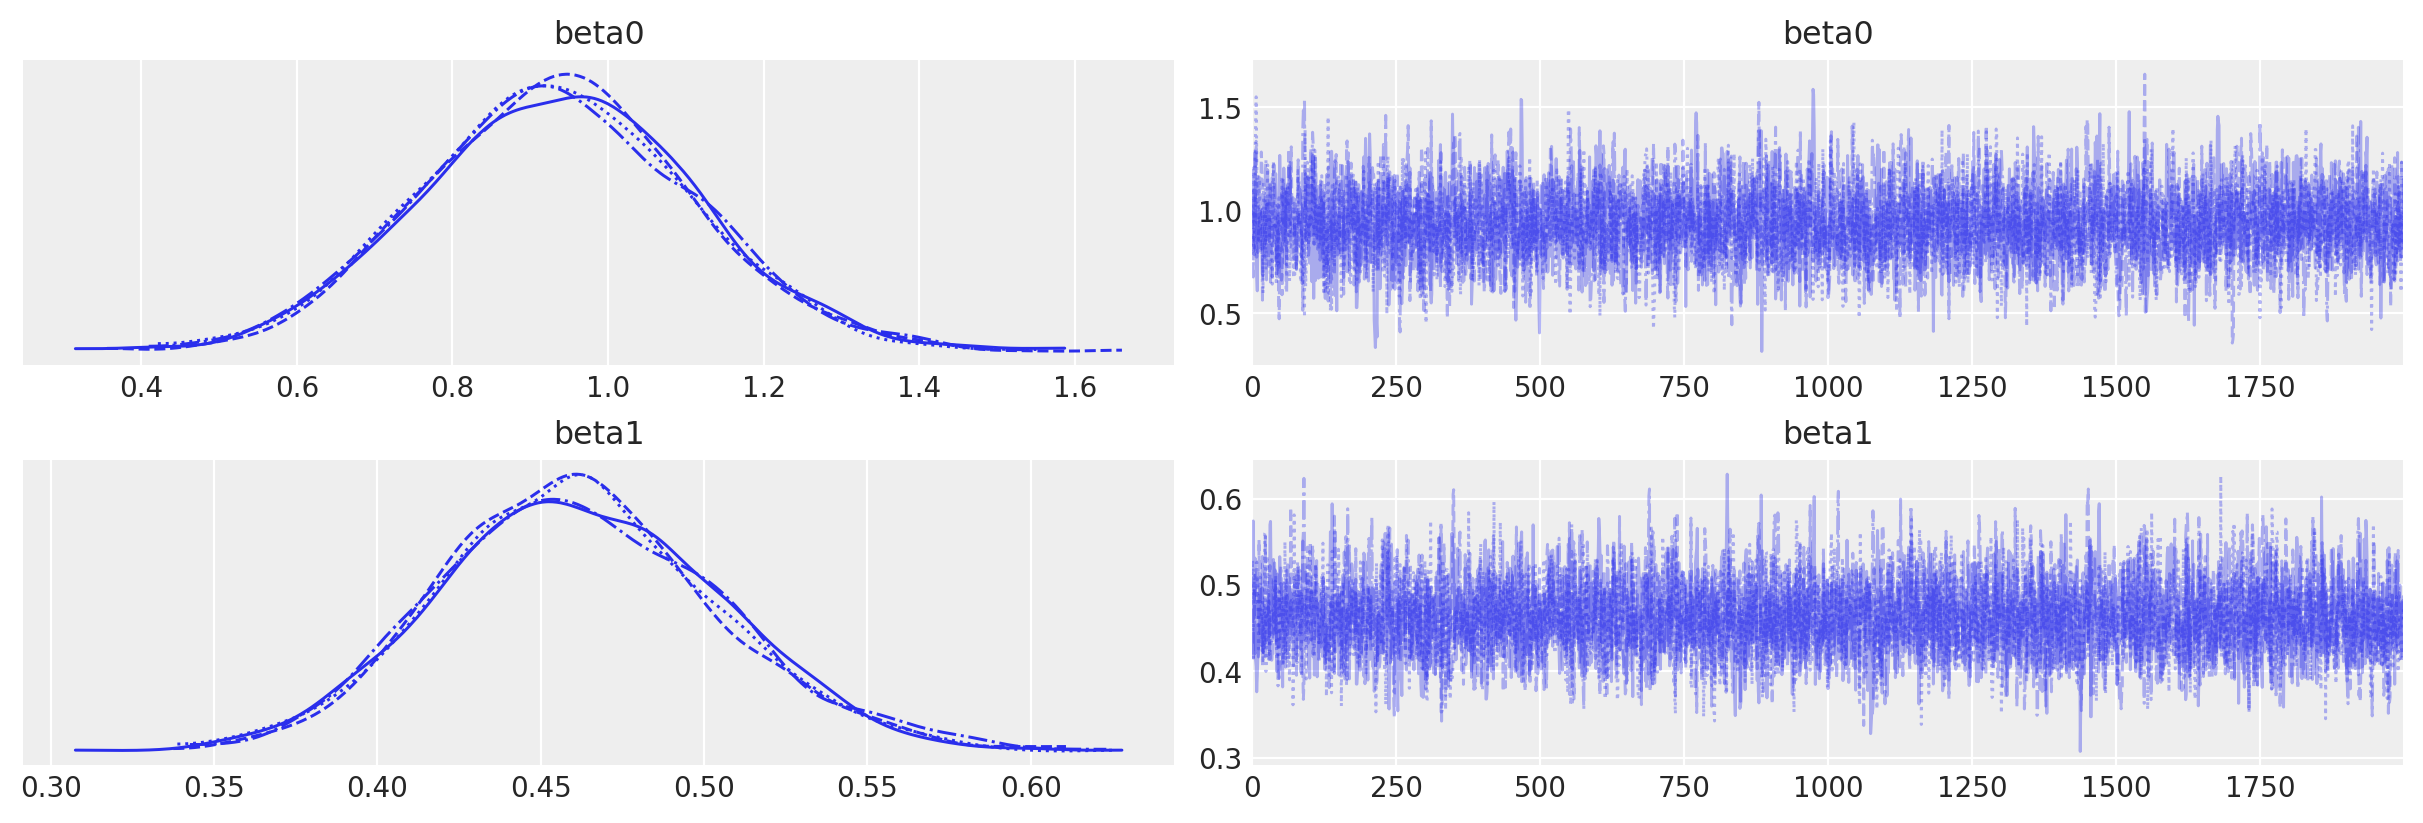

In [13]:
_ = az.plot_trace(fit, var_names=(["beta0", "beta1"]))

Nel pannello superiore della figura seguente vediamo il modello lineare nella sua forma non trasformata. Come si può osservare, questo modello lineare genera valori che escono dall'intervallo [0, 1], sottolineando quindi la necessità di una funzione di collegamento inversa. Questa funzione ha il compito di mappare i valori dal dominio dei numeri reali all'intervallo [0, 1]. Come abbiamo visto, questa trasformazione è realizzata mediante la funzione logistica inversa.

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_61676/1160461270.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


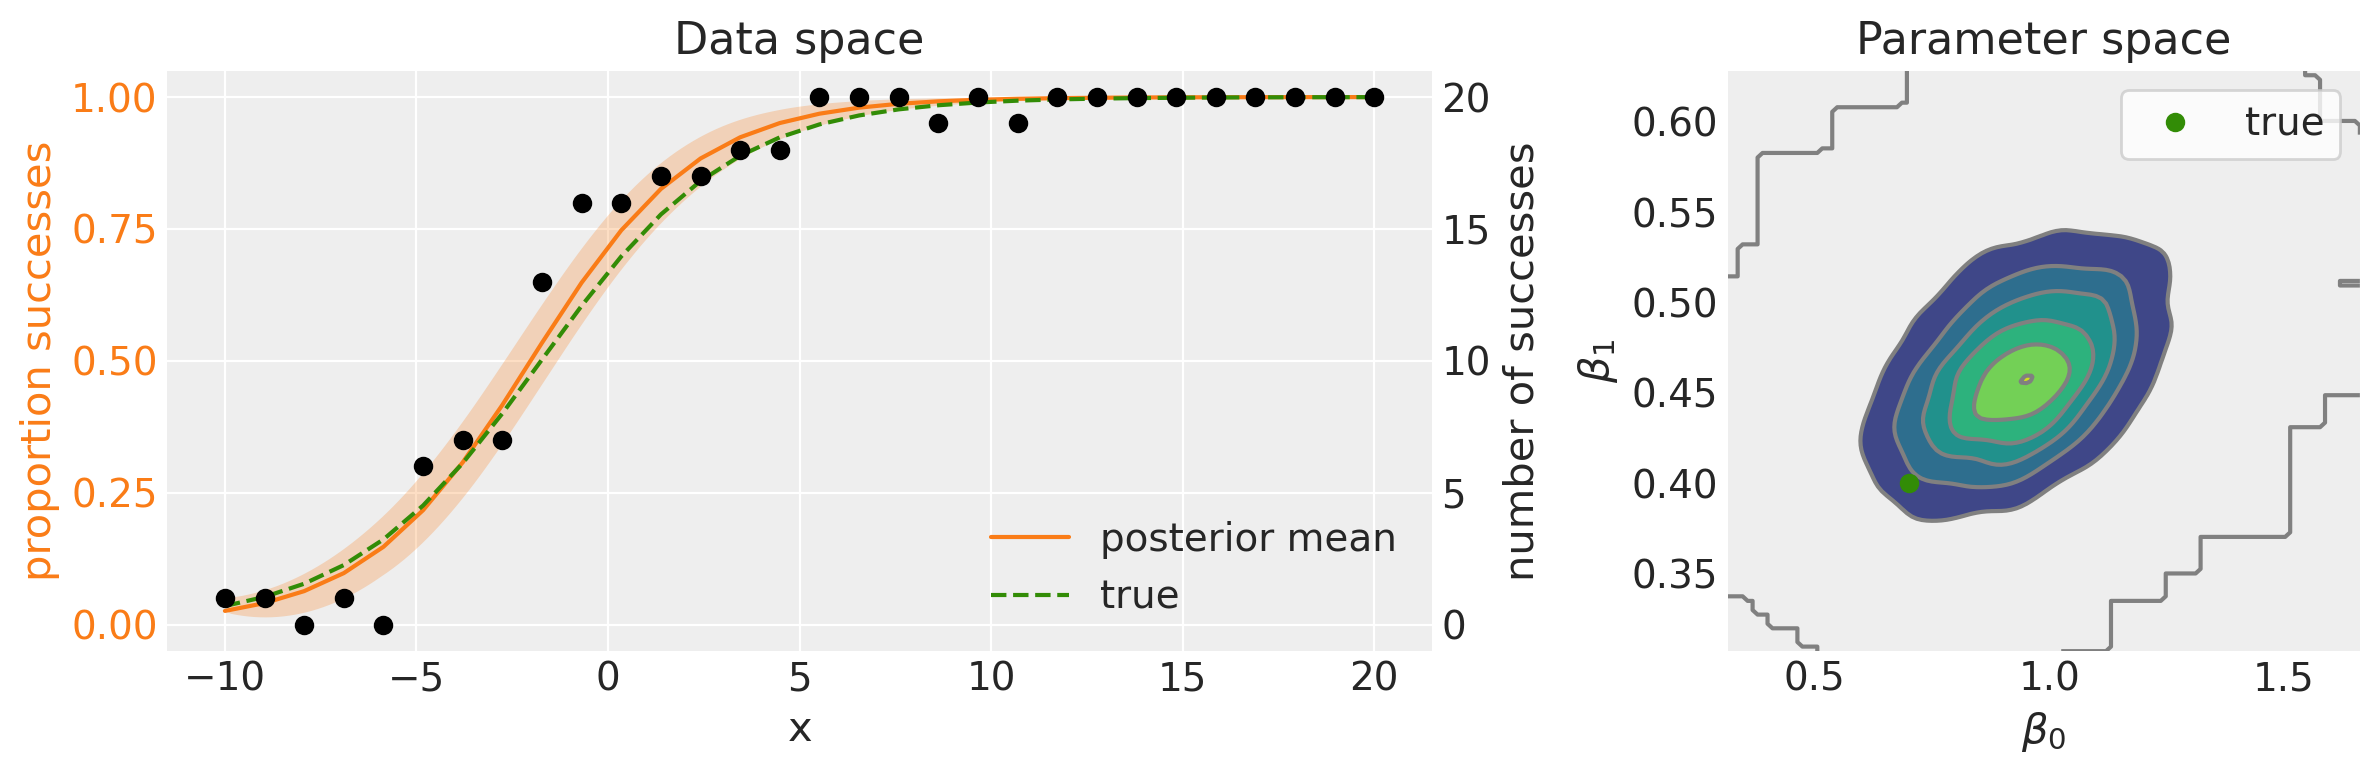

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True)
plt.tight_layout()

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Fri Jul 26 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanpy: 1.2.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
matplotlib: 3.9.1
arviz     : 0.18.0
pandas    : 2.2.2

Watermark: 2.4.3

